# Assess whether the model is spun up

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

isize = imax - imin
jsize = jmax - jmin

# evaluation date
year  = 2002
month = 8

# indices of stations:
stn_n = ['BB1', 'BB2', 'BB3', 'CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4']
stn_i = np.array([174, 337, 316, 444, 440, 431, 515, 515, 573, 554, 692, 582, 798, 848, 887, 969])
stn_j = np.array([405, 415, 382, 370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

# folders:
initial_conds = '/ocean/brogalla/GEOTRACES/data/Pb-tuning-202302/Pb-ini-20230214.nc' 

# colors
cmap   = matplotlib.cm.get_cmap('terrain')
colors = [matplotlib.colors.rgb2hex(cmap(i)) for i in np.linspace(0,0.95,len(stn_n))] # in hex format

#### Load files:

In [3]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]

e3t        = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)
hdept      = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [4]:
ref   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc',  'r')
depth = np.array(ref.variables['deptht'])

#### Calculations:

In [13]:
def create_file_list(folder):
    
    end_yr0       = [f'{initial_conds}' for month in range(1,13)]
    files_end_yr1 = [f'{folder}-spin0/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]
    files_end_yr2 = [f'{folder}-spin1/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]
    files_end_yr3 = [f'{folder}-spin2/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]
#     files_end_yr4 = [f'{folder}-spin3/ANHA12_EXH006_1m_20020101_20021231_comp_2002{month:02}-2002{month:02}.nc' for month in range(1,13)]

    file_list = end_yr0 + files_end_yr1 + files_end_yr2 + files_end_yr3 #+ files_end_yr4

    return file_list

In [9]:
def load_file(filename):
    
    pb_file    = nc.Dataset(f'{filename}')
    try:
        pb_monthly = np.array(pb_file.variables['dissolpb'])[0,:,:,:]
    except:
        pb_monthly = np.array(pb_file.variables['dPb'])[0,:,imin:imax,jmin:jmax]
    
    return pb_monthly

In [10]:
def calculate_monthly_difference(file_list):
    pb_monthly = np.zeros((len(file_list),50,isize,jsize))
    difference = np.zeros((len(file_list)-12,len(stn_i)))

    for f, filename in enumerate(file_list):
            pb_monthly[f,:,:,:] = load_file(filename)
            
            # for months after the end of the initial conditions:
            if (f > 11):
                
                # Calculate difference relative to same month in previous year and sum over all indices
                difference[f-12,:] = np.array([np.ma.sum(np.abs(pb_monthly[f,:,i,j] - \
                                                                pb_monthly[f-12,:,i,j])*e3t_masked[:,i,j]) / hdept[i,j] \
                                                            for i, j in zip(stn_i, stn_j)])
       
    return difference

The year-to-year change is calculated as the sum over all depths of the concentration at the observed stations, $stn$, for each month from one year compared to the previous year. 

$$ diff_{stn} = \frac{1}{hdept} \sum^{50}_{z=0} | Pb_{stn}(z,month,yr) - Pb_{stn}(z,month,yr-1) | e3t(z) $$

In [16]:
reference_files = create_file_list('/data/brogalla/run_storage/Pb-tuning-202302/Pb-tuning-202302-IC')

In [17]:
difference_reference = calculate_monthly_difference(reference_files)

#### Figures:

In [18]:
def plot_spinup_change(ax, difference, file_list, legend=False):

    months = range(1, len(reference_files)+1-12)
#     years  = np.linspace(2, 1+nruns, (nruns-1)*12 + 1)[0:-1]
    
    for stn, stn_name in enumerate(stn_n):
        ax.plot(months, difference[:,stn]*1e12, '-', c=colors[stn], label=stn_name, linewidth=1.5)
        ax.plot(months, difference[:,stn]*1e12, '.', c=colors[stn], markersize=6, markeredgecolor='k', markeredgewidth=0.5)

    # Line for spread in values
    ax.plot(months, (np.max(difference,axis=1)-np.min(difference,axis=1))*1e12, '--k', linewidth=1.2, label='spread')

#     ax.xaxis.set_ticks(np.linspace(2,2+nruns-1, (nruns-1)*2 + 1))
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    ax.set_ylabel(r'Pb change w.r.t. previous year [pmol L$^{-1}$]', fontsize=7)
    ax.set_xlabel('Months of spin up', fontsize=7);
    if legend:
        font = matplotlib.font_manager.FontProperties(size=7)
        ax.legend(loc=(0.8, 0.5), frameon=False, prop=font, ncol=2)
    
    return

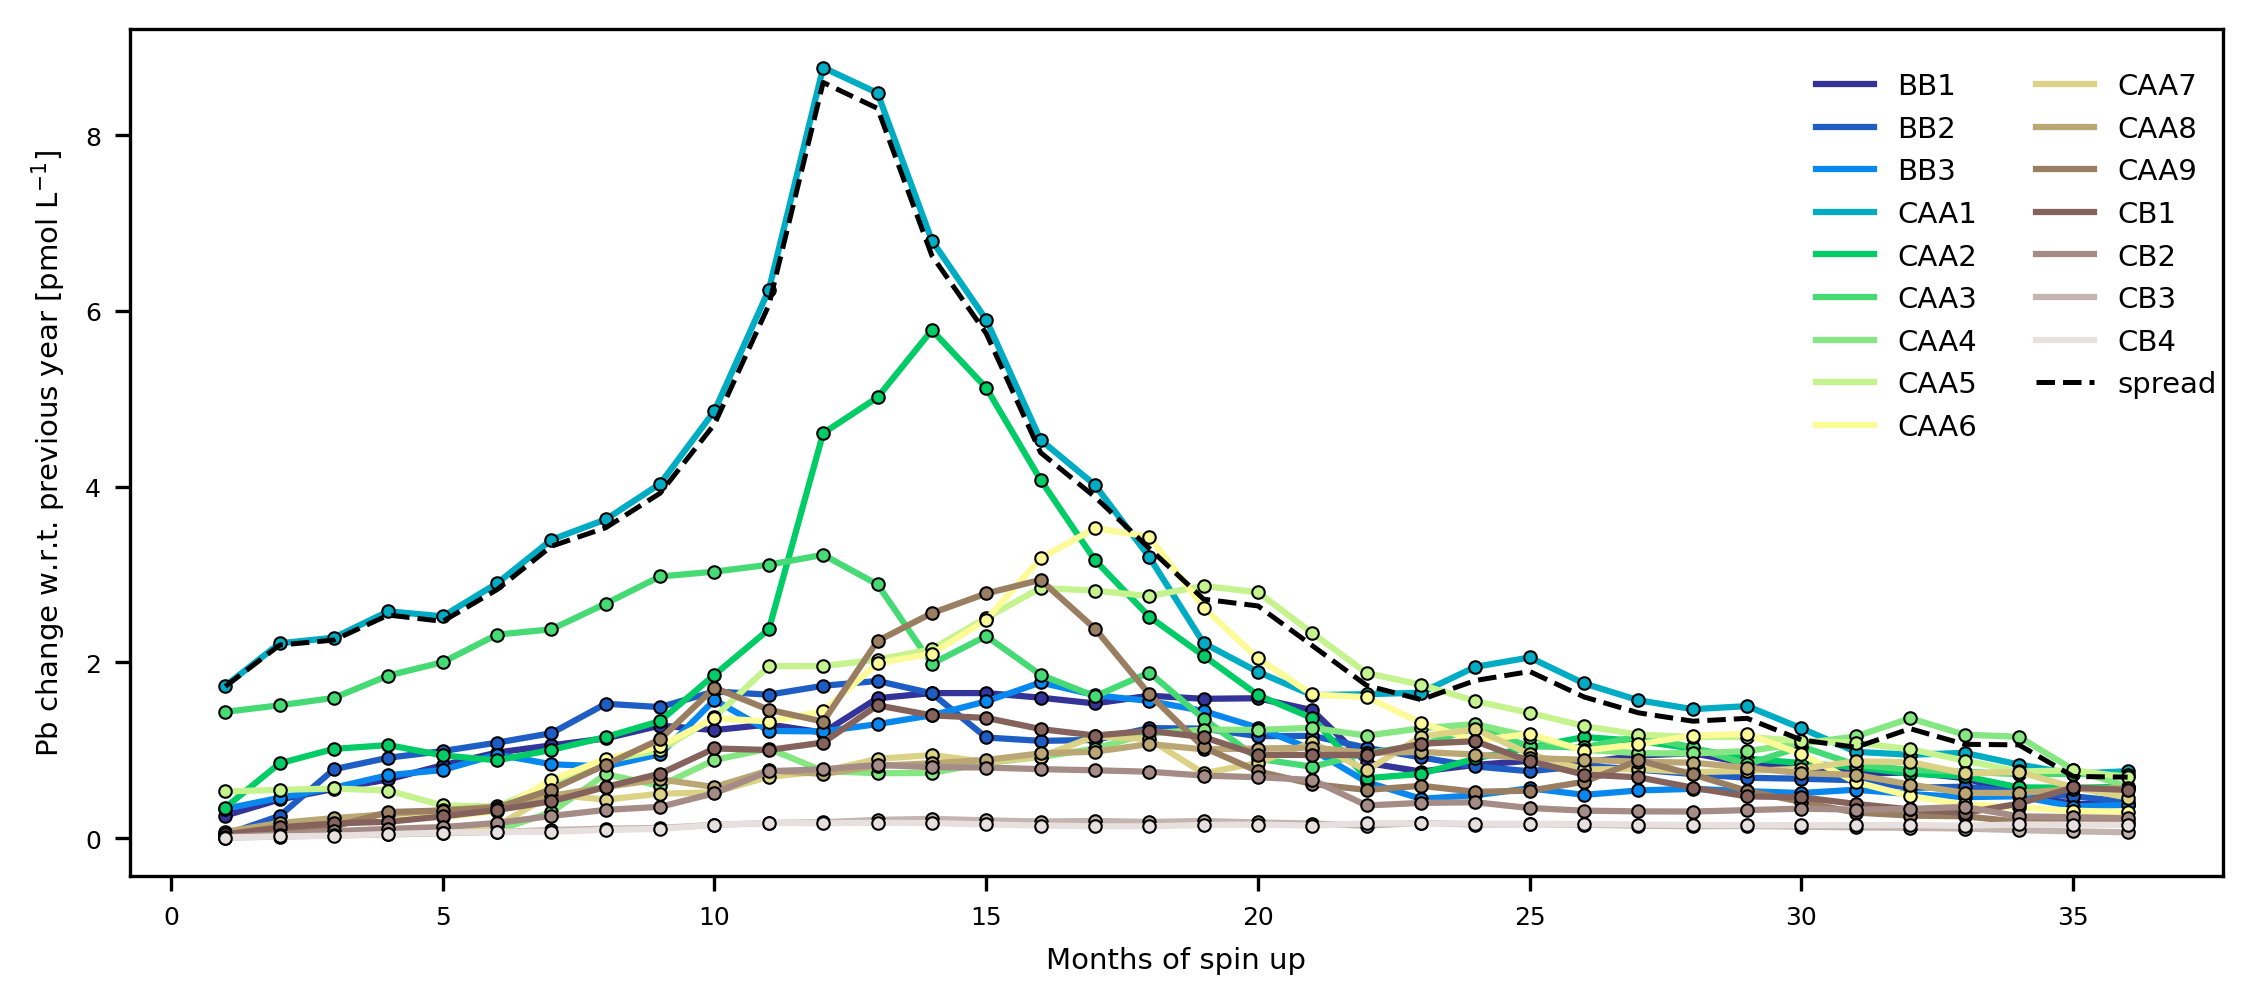

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4.5*2, 3.74), dpi=300)

plot_spinup_change(ax, difference_reference, reference_files, legend=True)